In [ ]:
import os

#Numpy is linear algebra lbrary
import numpy as np
# Matplotlib is a visualizations library 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Data Loader
transform = transforms.Compose(
    [   transforms.Resize((32,32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))])

batch_size = 32


dataset = '/content/gdrive/My Drive/Covid19-dataset'

train_directory = os.path.join(dataset, 'train')
test_directory = os.path.join(dataset, 'test')


trainset = torchvision.datasets.ImageFolder(root=train_directory, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.ImageFolder(root=test_directory, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

classes = ('Normal', 'Covid', 'Viral Pneumonia')

In [ ]:
train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

print(train_data_size)
print(test_data_size)

251
66


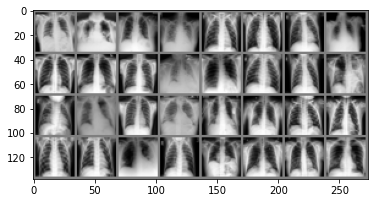

Normal Normal Normal Normal Viral Pneumonia Covid Viral Pneumonia Normal Covid Normal Covid Normal Normal Viral Pneumonia Viral Pneumonia Normal Viral Pneumonia Normal Covid Normal Normal Normal Covid Covid Viral Pneumonia Viral Pneumonia Normal Viral Pneumonia Normal Normal Covid Normal


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


In [ ]:
## 1. DEFINE MODEL 
model = nn.Sequential(nn.Linear(3072, 128),
                          nn.ReLU(),
                          nn.Linear(128, 64),
                          nn.ReLU(),
                          nn.Linear(64, 32),
                          nn.ReLU(),
                          nn.Linear(32, 3)
                          )

In [ ]:
# 2. LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

Sequential(
  (0): Linear(in_features=3072, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=3, bias=True)
)

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            #reshape images so they can be fed to a nn.Linear()
            inputs = inputs.view(inputs.size(0), -1)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                #reshape images so they can be fed to a nn.Linear()
                inputs = inputs.view(inputs.size(0), -1)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'cifar10_model_'+str(epoch)+'.pt')
            
    return model, history

In [ ]:
# 4. Train the model for 20 epochs

num_epochs = 20
trained_model, history = train_and_validate(model, criterion, optimizer, num_epochs)

Epoch: 1/20
Epoch : 000, Training: Loss: 1.1053, Accuracy: 27.8884%, 
		Validation : Loss : 1.0991, Accuracy: 30.3030%, Time: 49.5202s
Epoch: 2/20
Epoch : 001, Training: Loss: 1.0993, Accuracy: 27.8884%, 
		Validation : Loss : 1.0944, Accuracy: 30.3030%, Time: 13.9131s
Epoch: 3/20
Epoch : 002, Training: Loss: 1.0915, Accuracy: 29.8805%, 
		Validation : Loss : 1.0891, Accuracy: 31.8182%, Time: 14.1377s
Epoch: 4/20
Epoch : 003, Training: Loss: 1.0835, Accuracy: 47.8088%, 
		Validation : Loss : 1.0832, Accuracy: 57.5758%, Time: 14.8789s
Epoch: 5/20
Epoch : 004, Training: Loss: 1.0742, Accuracy: 66.1355%, 
		Validation : Loss : 1.0765, Accuracy: 62.1212%, Time: 14.2981s
Epoch: 6/20
Epoch : 005, Training: Loss: 1.0651, Accuracy: 74.1036%, 
		Validation : Loss : 1.0694, Accuracy: 62.1212%, Time: 13.4863s
Epoch: 7/20
Epoch : 006, Training: Loss: 1.0552, Accuracy: 76.0956%, 
		Validation : Loss : 1.0617, Accuracy: 62.1212%, Time: 16.1877s
Epoch: 8/20
Epoch : 007, Training: Loss: 1.0448, Accura

In [ ]:
history

[[1.1053126091026215,
  1.099142616445368,
  0.2788844632200036,
  0.30303030303030304],
 [1.0993190604852014,
  1.0944035522865527,
  0.27888446084531654,
  0.30303030303030304],
 [1.091474610020915,
  1.089104504296274,
  0.29880478111396275,
  0.3181818181818182],
 [1.0835183483670907,
  1.0832240942752722,
  0.4780876515396088,
  0.5757575757575758],
 [1.0742047673677544,
  1.0765193953658596,
  0.6613545847603999,
  0.6212121212121212],
 [1.0651163522940708,
  1.0694062276320024,
  0.7410358556238303,
  0.6212121212121212],
 [1.055166028410315,
  1.0617294094779275,
  0.760956176723617,
  0.6212121212121212],
 [1.0448048898423334,
  1.05286101138953,
  0.7729083679586768,
  0.6212121212121212],
 [1.032675082465092,
  1.0423477960355354,
  0.7888446236511626,
  0.6060606060606061],
 [1.0192769376405206,
  1.0307994936451768,
  0.7968127504287963,
  0.6363636363636364],
 [1.004139585798955,
  1.0174149040019873,
  0.8207171328989158,
  0.6363636363636364],
 [0.9874937068893614,
  1.

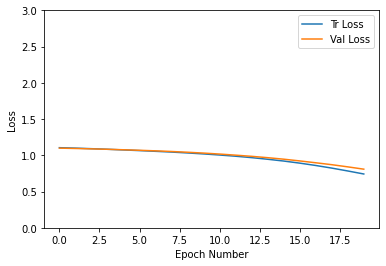

In [ ]:
# 5. Analyze the loss curve

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
# plt.savefig('cifar10_loss_curve.png')
plt.show()

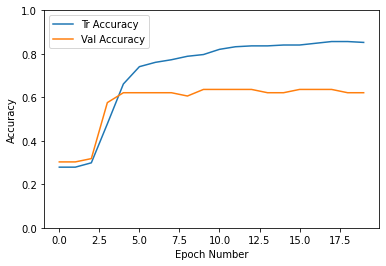

In [ ]:
# 6. Analyze the accuracy curve

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('cifar10_accuracy_curve.png')
plt.show()

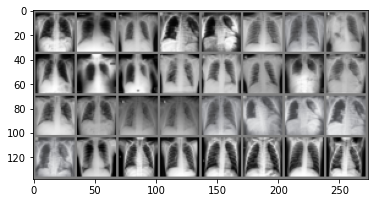

GroundTruth:  Normal Normal Normal Normal


In [ ]:
dataiter = iter(testloader)

images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
images.shape

torch.Size([32, 3, 32, 32])

In [ ]:
# again, need to flatten the image
images = images.to(device)
images = images.view(images.size(0), -1)
outputs = model(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  Normal Normal Normal Normal


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
#         images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        images = images.view(images.size(0), -1)
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 39 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        images = images.view(images.size(0), -1)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Normal is 100.0 %
Accuracy for class: Covid is 0.0 %
Accuracy for class: Viral Pneumonia is 0.0 %


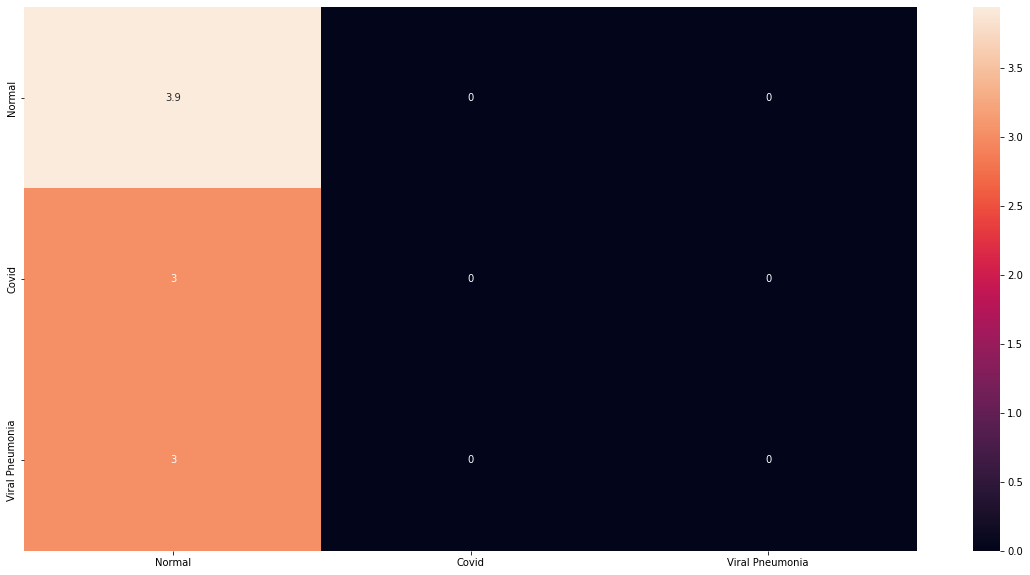

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

model.to('cpu')

# iterate over test data
for inputs, labels in testloader:
        #reshape images so they can be fed to a nn.Linear()
        inputs = inputs.view(inputs.size(0), -1)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('Normal', 'Covid', 'Viral Pneumonia')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)
# plt.savefig('output.png')